## CEMA Africa Computer Science Internship
### Name : Sharon Atieno
### Task : Classify whether a blood smear is uninfected or parasitized using Tensorflow
### Deadline : 15th/May/2024, Wednesday

In [50]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import regularizers



import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import tensorflow as tf
import tensorflow_datasets as tfds

Load Data

In [30]:
[train_df, validation_df, test_df], info = tfds.load(
    'malaria', 
    split = ['train[:70%]', 'train[70%:85%]', 'train[85%:]'], 
    shuffle_files = True, 
    with_info = True)

In [ ]:
Data Understanding

In [38]:
print(f"Training Dataset Structure:\n{str(train_df)}")
print(f"Dataset info:\n{str(info)}")

df_size = info.splits["train"].num_examples
df_names = info.features["label"].names
df_classes = info.features["label"].num_classes

print(f"Number of Training Samples:\n{str(df_size)}")
print(f"Classes:\n{str(df_names)}")
print(f"Num of Classes:\n{str(df_classes)}")

Training Dataset Structure:
<_PrefetchDataset element_spec={'image': TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None)}>
Dataset info:
tfds.core.DatasetInfo(
    name='malaria',
    full_name='malaria/1.0.0',
    description="""
    The Malaria dataset contains a total of 27,558 cell images with equal instances
    of parasitized and uninfected cells from the thin blood smear slide images of
    segmented cells.
    """,
    homepage='https://lhncbc.nlm.nih.gov/publication/pub9932',
    data_dir='C:\\Users\\Atieno\\tensorflow_datasets\\malaria\\1.0.0',
    file_format=tfrecord,
    download_size=337.08 MiB,
    dataset_size=317.62 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=2

Based on the information above we are able to key information :
1. The number of cell images contained in the Malaria Dataset is 27,558
2. The dataset contains 2 classes
3. The labels of the classes are "parasitized" and "uninfected"

In [40]:
# display few samples of images
# this is to check the images are all different sizes
# take a look at the shape
for image in train_df.take(4):
    print(image)


{'image': <tf.Tensor: shape=(103, 103, 3), dtype=uint8, numpy=
array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)>, 'label': <tf.Tensor: shape=(), dtype=int64, numpy=0>}
{'image': <tf.Tensor: shape=(115, 157, 3), dtype=uint8, numpy=
array([[[0, 0, 0],

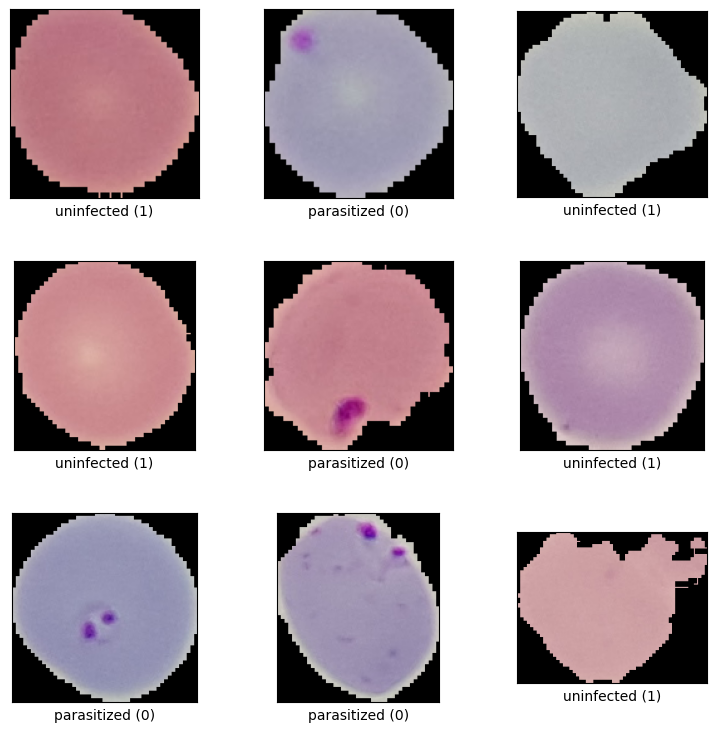

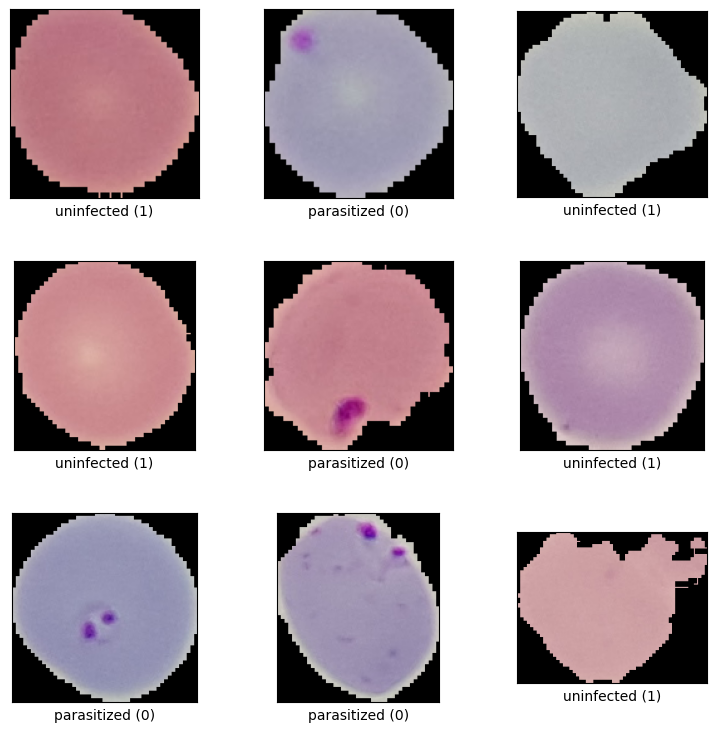

In [41]:
# preview cell images
figures = tfds.show_examples(train_df, info)
figures

In [56]:
set_height = 200
set_width = 200
batch_size = 32

In [57]:
def standard_image_size(dataframe):
    dataframe['image'] = tf.image.convert_image_dtype(dataframe['image'], tf.float32)
    dataframe['image'] = tf.image.resize_with_crop_or_pad(dataframe["image"], set_height, set_width)
    return dataframe['image'], dataframe['label']

In [46]:
standardized_train_df = train_df.map(standard_image_size).batch(batch_size)
standardized_validation_df = validation_df.map(standard_image_size).batch(batch_size)
standardized_test_df = test_df.map(standard_image_size).batch(batch_size)

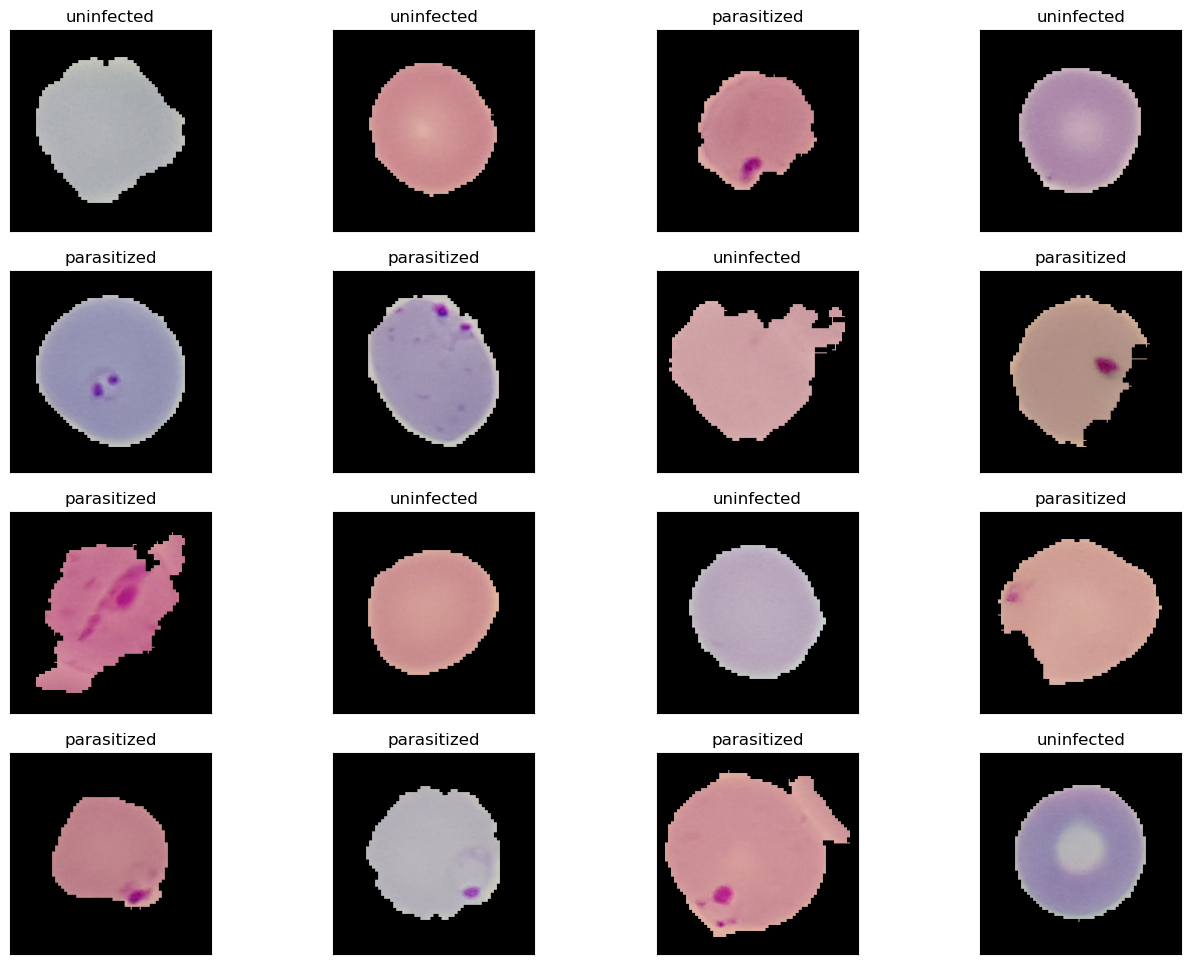

In [52]:
batch_image, batch_label = next(iter(standardized_train_df))
plt.figure(figsize = (16, 12))

for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.imshow(batch_image[i])
    if batch_label[i]:
        plt.title(df_names[1])
    else:
        plt.title(df_names[0])

Base Model 

In [53]:
def build_model(input_shape = [set_height, set_width, 3]):
    model = Sequential()

    model.add(Dense(64, activation = 'tanh', input_shape = input_shape))
    model.add(Dense(10, activation = 'softmax'))

    model.compile(loss = 'categorical_crossentropy', optimizer = 'sgd', metrics = ['acc'])
    return model

In [54]:
base_model = build_model()
base_model.summary()

c:\Users\Atieno\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 200, 200, 64)   │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 200, 200, 10)   │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 906 (3.54 KB)

 Trainable params: 906 (3.54 KB)

 Non-trainable params: 0 (0.00 B)

In [58]:
# history = base_model.fit(standardized_train_df, epochs = 40, validation_data = standardized_validation_df)